<a href="https://colab.research.google.com/github/aureliowozhiak/Bootcamp-Data-Science-Aplicada/blob/main/md_06_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

dados = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
dados.head()

PATIENT_VISIT_IDENTIFIER  AGE_ABOVE65  ...    WINDOW  ICU
0                         0            1  ...       0-2    0
1                         0            1  ...       2-4    0
2                         0            1  ...       4-6    0
3                         0            1  ...      6-12    0
4                         0            1  ...  ABOVE_12    1

[5 rows x 231 columns]

In [2]:
def preenche_tabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

In [3]:
dados_limpos = preenche_tabela(dados)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()
dados_limpos.describe()

PATIENT_VISIT_IDENTIFIER  ...          ICU
count               1760.000000  ...  1760.000000
mean                 192.818182  ...     0.201705
std                  110.637724  ...     0.401387
min                    0.000000  ...     0.000000
25%                   97.750000  ...     0.000000
50%                  191.500000  ...     0.000000
75%                  289.250000  ...     0.000000
max                  384.000000  ...     1.000000

[8 rows x 229 columns]

In [4]:
def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype("category").cat.codes
dados_limpos.head()

PATIENT_VISIT_IDENTIFIER  AGE_ABOVE65  ...  WINDOW  ICU
PATIENT_VISIT_IDENTIFIER                                            ...             
0                        0                          0            1  ...     0-2    1
2                        10                         2            0  ...     0-2    1
3                        15                         3            0  ...     0-2    0
4                        20                         4            0  ...     0-2    0
5                        25                         5            0  ...     0-2    0

[5 rows x 231 columns]

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

np.random.seed(73246)


x_columns = dados.columns
y = dados_limpos["ICU"]
x = dados_limpos[x_columns].drop(["ICU","WINDOW"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
modelo = DummyClassifier()
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.48863636363636365

In [13]:
modelo = LogisticRegression(max_iter=10000)
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

0.6818181818181818

In [14]:
for coluna in dados.columns:
    if coluna not in x_columns:
        print(coluna)

In [21]:
from sklearn.tree import DecisionTreeClassifier

modelo_arvore = DecisionTreeClassifier()
modelo_arvore.fit(x_train, y_train)
predicao_arvore = modelo_arvore.predict(x_test)
accuracy_score(y_test, predicao_arvore)

0.6590909090909091

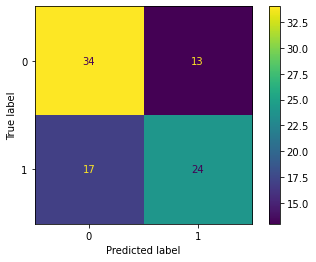

In [22]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(modelo_arvore, x_test, y_test)

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicao_arvore))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69        47
           1       0.65      0.59      0.62        41

    accuracy                           0.66        88
   macro avg       0.66      0.65      0.65        88
weighted avg       0.66      0.66      0.66        88

